In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR 
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


## Split Training & Testing Data


*   Training data: 2005 - 2018
*   Testing data: 2019 - 2021



|     Model     | factor | Window size | Step size | Horizon |
| :-----------: | :----: | :---------: | :-------: | :-----: |
|  1 day ahead  | close  |      3      |     1     |    1    |
|               |  all   |      3      |     1     |    1    |
| 5 days ahead  | close  |      8      |     1     |    5    |
|               |  all  |      8      |     1     |    5    |
| 22 days ahead | close |     25      |     1     |   22    |
|               |  all  |     25      |     1     |   22    |

In [ ]:
# Read data & split by year
def split_train_test(file_path, start_year, mid_year, final_year):
  full_dataset = pd.read_excel(file_path).loc[:, 'Date - 0':]
  training_ori = full_dataset[full_dataset['Date - 0'].dt.year.isin(np.arange(start_year, mid_year))]
  testing_ori = full_dataset[full_dataset['Date - 0'].dt.year.isin(np.arange(mid_year, final_year))]
  return training_ori, testing_ori

### Data Select
1.   ONE day ahead


*   close (1c)
*   all factors (1a)



2.   FIVE days ahead


*   close (5c)
*   all factors (5a)



3.   TWENTY-TWO days ahead

*   close (22c)
*   all factors (22a)


In [ ]:
def create_train_test_dataset(file_path, file_name, start_year, mid_year, final_year, pred_factor, window_size, horizon):
  training_ori, testing_ori = split_train_test(file_path + file_name, start_year, mid_year, final_year)
  
  # factor = all
  X_train_a = training_ori.iloc[:, 1: -1 * (horizon)]
  X_test_a = testing_ori.iloc[:, 1: -1 * (horizon)]

  # factor = close
  X_train_c = training_ori.loc[:, pred_factor +  ' - ' + str(window_size - 1): pred_factor + ' - 0']
  X_test_c = testing_ori.loc[:, pred_factor +  ' - ' + str(window_size - 1): pred_factor + ' - 0']

  Y_train = training_ori.iloc[:, -1]
  Y_test = testing_ori.iloc[:, -1]
  
  return X_train_a, X_test_a, X_train_c, X_test_c, Y_train, Y_test

In [ ]:
file_path = '/content/drive/MyDrive/EC503/Coding/Summary/DataSource/'
file_name = ['PingAn_3_1.xlsx', 'PingAn_8_5.xlsx', 'PingAn_25_22.xlsx']
X_train_1a, X_test_1a, X_train_1c, X_test_1c, Y_train_1, Y_test_1 = create_train_test_dataset(file_path, file_name[0], 2005, 2019, 2022, 'close', 3, 1)
X_train_5a, X_test_5a, X_train_5c, X_test_5c, Y_train_5, Y_test_5 = create_train_test_dataset(file_path, file_name[1], 2005, 2019, 2022, 'close', 8, 5)
X_train_22a, X_test_22a, X_train_22c, X_test_22c, Y_train_22, Y_test_22 = create_train_test_dataset(file_path, file_name[2], 2005, 2019, 2022, 'close', 25, 22)

In [ ]:
X_train = np.array([X_train_1a.values, X_train_1c.values, X_train_5a.values, X_train_5c.values, X_train_22a.values, X_train_22c.values],dtype=object)
X_test = np.array([X_test_1a.values, X_test_1c.values, X_test_5a.values, X_test_5c.values, X_test_22a.values, X_test_22c.values],dtype=object)
Y_train = np.array((Y_train_1.values, Y_train_5.values, Y_train_22.values),dtype=object)
Y_test = np.array([Y_test_1.values, Y_test_5.values, Y_test_22.values],dtype=object)

In [ ]:
Train_dt = []
Test_dt = []
for i in range(6):
  Train_dt.append(np.concatenate((X_train[i],Y_train[i//2].reshape(-1, 1)), axis=1))
  Test_dt.append(np.concatenate((X_test[i],Y_test[i//2].reshape(-1, 1)), axis=1))

## Support Vector Regression & Kernel Ridge Regression 
### Tune parameters by GridSearchCV

SVM


In [ ]:
C_svr = np.logspace(3, 5, 3)
gamma_svr = np.logspace(-11, -5, 7)
parameters_svr = {
    'kernel' : ['rbf'],
    'C': C_svr,
    'gamma': gamma_svr
}

grid_svr = GridSearchCV(SVR(), parameters_svr, cv = 5, verbose = 1)
# grid_svr = SVR(kernel = 'rbf', gamma = 1e-6, C = 1e5)

KRR


In [ ]:
alpha_krr = np.logspace(-5, 0, 6)
gamma_krr = np.logspace(-9, -4, 6)
parameters_krr = {
    'kernel' : ['rbf'],
    'alpha': alpha_krr,
    'gamma': gamma_krr
}

grid_krr = GridSearchCV(KernelRidge(), parameters_krr, cv = 5, verbose = 1)
# grid_krr = KernelRidge(kernel='rbf', alpha=1e-05, gamma=0.0001)

Normalization & train & predict

In [ ]:
def normalization_train_pred(Train_dt, Test_dt):
  C_svr = np.logspace(3, 5, 3)
  gamma_svr = np.logspace(-11, -5, 7)
  parameters_svr = {
      'kernel' : ['rbf'],
      'C': C_svr,
      'gamma': gamma_svr
  }

  grid_svr = GridSearchCV(SVR(), parameters_svr, cv = 5, verbose = 1)
  # grid_svr = SVR(kernel = 'rbf', gamma = 1e-6, C = 1e5)

  alpha_krr = np.logspace(-5, 0, 6)
  gamma_krr = np.logspace(-9, -4, 6)
  parameters_krr = {
      'kernel' : ['rbf'],
      'alpha': alpha_krr,
      'gamma': gamma_krr
  }

  grid_krr = GridSearchCV(KernelRidge(), parameters_krr, cv = 5, verbose = 1)
  # grid_krr = KernelRidge(kernel='rbf', alpha=1e-05, gamma=0.0001)
  
  best_param_svr = []
  MAPE_svr = []
  Y_pred_svr = []

  best_param_krr = []
  MAPE_krr = []
  Y_pred_krr = []

  for i in range(6):
    # Normalize
    sc = MinMaxScaler()
    train_sc = sc.fit_transform(Train_dt[i])
    X_train_sc = train_sc[:, :-1]
    Y_train_sc = train_sc[:, -1]

    Y_test_ori = Test_dt[i][:, -1]
    test_sc = sc.transform(Test_dt[i])
    X_test_sc = test_sc[:, :-1]
    Y_test_sc = test_sc[:, -1]

    # support vector regression
    grid_svr.fit(X_train_sc, Y_train_sc)
    Y_pred_svr_sc = grid_svr.predict(X_test_sc)
    test_sc_svr = np.concatenate((X_test_sc,Y_pred_svr_sc.reshape(-1, 1)), axis=1)
    test_inv_svr = sc.inverse_transform(test_sc_svr)
    Y_svr = test_inv_svr[:, -1]
    Y_pred_svr.append(Y_svr)

    best_param_svr.append(grid_svr.best_estimator_)
    MAPE_svr.append(round(mean_absolute_percentage_error(Y_svr, Y_test_ori), 2))

    # kernel ridge regression
    grid_krr.fit(X_train_sc, Y_train_sc)
    Y_pred_krr_sc = grid_krr.predict(X_test_sc)
    test_sc_krr = np.concatenate((X_test_sc,Y_pred_krr_sc.reshape(-1, 1)), axis=1)
    test_inv_krr = sc.inverse_transform(test_sc_krr)
    Y_krr = test_inv_krr[:, -1]
    Y_pred_krr.append(Y_krr)

    best_param_krr.append(grid_krr.best_estimator_)
    MAPE_krr.append(round(mean_absolute_percentage_error(Y_krr, Y_test_ori), 2))
  return best_param_svr, MAPE_svr, best_param_krr, MAPE_krr, Y_pred_svr, Y_pred_krr

In [ ]:
best_param_svr, MAPE_svr, best_param_krr, MAPE_krr, Y_pred_svr, Y_pred_krr = normalization_train_pred(Train_dt, Test_dt)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 21 candidates, totalling 105 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 21 candidates, totalling 105 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 21 candidates, totalling 105 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 21 candidates, totalling 105 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 21 candidates, totalling 105 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [ ]:
print(best_param_svr, best_param_krr, MAPE_svr, MAPE_krr)

[SVR(C=10000.0, gamma=1e-05), SVR(C=100000.0, gamma=1e-05), SVR(C=100000.0, gamma=1e-06), SVR(C=100000.0, gamma=1e-05), SVR(C=100000.0, gamma=1e-07), SVR(C=100000.0, gamma=1e-06)] [KernelRidge(alpha=1e-05, gamma=0.0001, kernel='rbf'), KernelRidge(alpha=1e-05, gamma=0.0001, kernel='rbf'), KernelRidge(alpha=0.0001, gamma=0.0001, kernel='rbf'), KernelRidge(alpha=1e-05, gamma=0.0001, kernel='rbf'), KernelRidge(alpha=0.001, gamma=0.0001, kernel='rbf'), KernelRidge(alpha=1e-05, gamma=1e-05, kernel='rbf')] [0.03, 0.02, 0.04, 0.04, 0.09, 0.1] [0.02, 0.02, 0.05, 0.04, 0.17, 0.1]


|     Model     |   factor    |      1 - MAPE |      |      |
| :-----------: | :---------: | :--: | :--: | :--: |
|               |             | KRR  | SVR  |      |
|  1 day ahead  | close  |  98%  |  98%  |      |
|               |  all   |  97%  |  98%  |      |
| 5 days ahead  | close  |  96%  |  96%  |      |
|               |  all   |  96%  |  95%  |      |
| 22 days ahead | close  |  90%  |  90%  |      |
|               |  all   |  91%  |  83%  |      |

### Plot Part

In [ ]:
def Plot_pred_price(Y_pred_svr, Y_pred_krr, Company_name):
  titles = ['1 day ahead', '5 days ahead', '22 days ahead']
  sub_plot = [231, 232, 233, 234, 235, 236]
  plt.figure(figsize=(18, 10))
  plt.suptitle('Close Price Prediction of ' + Company_name)
  for i in range(3):
    size = Y_test[i].shape[0]
    plt.subplot(sub_plot[i])
    plt.plot(range(size), Y_test[i], color = 'red', label='real stock price')
    plt.plot(range(size), Y_pred_svr[2*i], color = 'blue', label='all factors')
    plt.plot(range(size), Y_pred_svr[2*i+1], color = 'green', label='close')
    plt.title('Stock predict (SVR) ' + titles[i])
    plt.xlabel('date')
    plt.ylabel('Close value')
    plt.legend()

    plt.subplot(sub_plot[i + 3])
    plt.plot(range(size), Y_test[i], color = 'red', label='real stock price')
    plt.plot(range(size), Y_pred_krr[2*i], color = 'blue', label='all factors')
    plt.plot(range(size), Y_pred_krr[2*i+1], color = 'green', label='close')
    plt.title('Stock predict (KRR) ' + titles[i])
    plt.xlabel('date')
    plt.ylabel('Close value')
    plt.legend()
  plt.show()

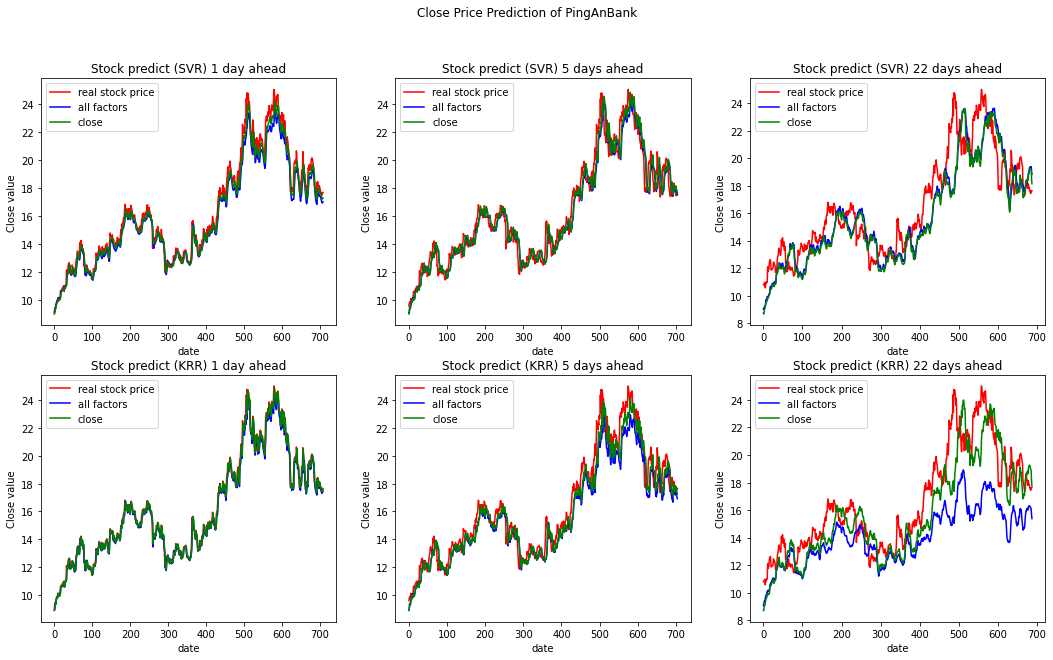

In [ ]:
Plot_pred_price(Y_pred_svr, Y_pred_krr, 'PingAnBank')